In [1]:
from pathlib import Path

from Bio.PDB.DSSP import make_dssp_dict
import pandas as pd
from Bio.Data.IUPACData import protein_letters_3to1

In [8]:
dssp_dir = Path('../data/processed/dssp_alphafold')
dfs = []
for dssp_file_path in dssp_dir.iterdir():
    dssp = make_dssp_dict(dssp_file_path)
    dfs.append(pd.DataFrame(data=[(dssp_file_path.stem, k[1][1], v[0], v[1], v[2]) for k, v in dssp[0].items()],
                      columns=['clone_name', 'position', 'aa', 'secondary_structure', 'ASA']))
df = pd.concat(dfs, axis=0, ignore_index=True)
# NOTE: the Davey analysis uses GGXGG whereas I think this paper is GXG
# Wilke: Tien et al. 2013 https://doi.org/10.1371/journal.pone.0080635
max_asa = {
        "ALA": 129.0,
        "ARG": 274.0,
        "ASN": 195.0,
        "ASP": 193.0,
        "CYS": 167.0,
        "GLN": 225.0,
        "GLU": 223.0,
        "GLY": 104.0,
        "HIS": 224.0,
        "ILE": 197.0,
        "LEU": 201.0,
        "LYS": 236.0,
        "MET": 224.0,
        "PHE": 240.0,
        "PRO": 159.0,
        "SER": 155.0,
        "THR": 172.0,
        "TRP": 285.0,
        "TYR": 263.0,
        "VAL": 174.0,
    }
max_asa = {protein_letters_3to1[k.capitalize()]: v for k, v in max_asa.items()}
df['RSA'] = df['ASA'] / df['aa'].map(max_asa)
df['RSA'] = df['RSA'].clip(upper=1.)
WINDOW_SIZE_RESIDUES = 20
DISORDER_WINDOW_RSA_CUTOFF = 0.5
rsa_window_col = f'RSA_window_{WINDOW_SIZE_RESIDUES}'
"""
df[rsa_window_col] = (
    df['RSA'].rolling(window=WINDOW_SIZE_RESIDUES * 2 + 1,
                  min_periods=WINDOW_SIZE_RESIDUES + 1,
                  center=True)
             .mean())
"""
df[rsa_window_col] = (
         df.groupby('clone_name')['RSA']
           .rolling(window=WINDOW_SIZE_RESIDUES * 2 + 1,
                  min_periods=WINDOW_SIZE_RESIDUES + 1,
                  center=True)
             .mean().rename(rsa_window_col).droplevel('clone_name')
)
df['is_disordered'] = df[rsa_window_col] >= DISORDER_WINDOW_RSA_CUTOFF

In [9]:
df['secondary_structure'].value_counts()

-    151527
H     75987
T     20315
E     17677
S     15462
G      4997
B       910
I       682
Name: secondary_structure, dtype: int64

In [10]:
# add the helix thing
DISORDER_HELIX_LENGTH_CUTOFF = 20
to_change = []
for clone_name, df_clone in df.groupby('clone_name'):
    helix_count = 0
    for _i, row in df_clone.iterrows():
        if row['secondary_structure'] == 'H':
            helix_count += 1
        else:
            if helix_count >= DISORDER_HELIX_LENGTH_CUTOFF:
                for i in range(row['position'] - 1, row['position'] - helix_count, -1):
                    to_change.append((clone_name, i))
            helix_count = 0
    if helix_count >= DISORDER_HELIX_LENGTH_CUTOFF:
        for i in range(row['position'], row['position'] - helix_count, -1):
            to_change.append((clone_name, i))
to_change = (df['clone_name'] + '_' + df['position'].astype(str)).isin({a + '_' + str(b) for a, b in to_change})
print(f'{to_change.sum()} ({to_change.mean():.0%}) aa in helices of length 20 aa or more')
print(f"{df.loc[to_change, 'is_disordered'].mean():.0%} of residues in long helices misclassified as disordered")
df.loc[to_change, 'is_disordered'] = False

24979 (9%) aa in helices of length 20 aa or more
29% of residues in long helices misclassified as disordered


In [56]:
df.to_csv('data/processed/TFiso1_disorder-and-ss_from-alphafold.tsv',
          index=False, sep='\t')

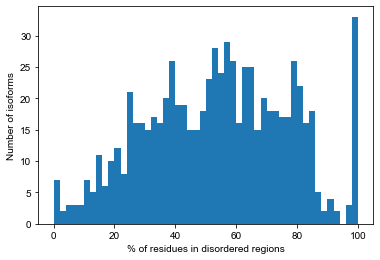

In [28]:
# plot disordered fraction of isoforms
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1)
f_dis = df.groupby('clone_name')['is_disordered'].mean()
(f_dis * 100).plot.hist(range=(0, 100), bins=50, ax=ax)
ax.set_ylabel('Number of isoforms')
ax.set_xlabel('% of residues in disordered regions')
fig.savefig('../figures/disordered-residued-pct-per-isoform_TFiso1_histogram.pdf', 
    bbox_inches='tight')

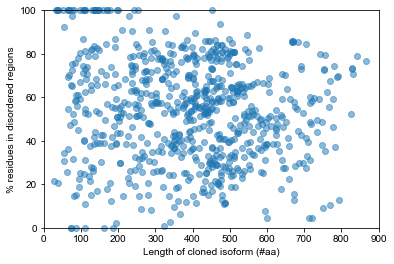

In [29]:
# TODO: color by family
# TODO: split by reference and alternative isoforms
fig, ax = plt.subplots(1, 1)
ax.scatter(df.groupby('clone_name').size(), 
           df.groupby('clone_name')['is_disordered'].mean() * 100,
           clip_on=False,
           alpha=0.5)
ax.set_ylim(0, 100)
ax.set_xlim(0, 900)
ax.set_xlabel('Length of cloned isoform (#aa)')
ax.set_ylabel('% residues in disordered regions')
fig.savefig('../figures/disordered-residued-pct-per-isoform-vs-length_TFiso1_scatter.pdf', 
    bbox_inches='tight')

In [ ]:
# plots of length of disordered sequence?

In [ ]:
# comparison of reference to alternative isoforms


In [ ]:
# pairwise metrics of disorder/order
# - number of ordered residues different
# - number of disordered residues different


In [11]:
# lazy version: delta disordered residues
# for each isoform: number of residues, disordered residues and ordered residues
# for each pair, delta of all
n_aa = df.groupby('clone_name').size().rename('n_aa').to_frame()
n_aa['n_aa_disordered'] = df.groupby('clone_name')['is_disordered'].sum()
n_aa['n_aa_ordered'] = n_aa['n_aa'] - n_aa['n_aa_disordered']

In [5]:
from isoform_pairwise_metrics import pairs_of_isoforms_comparison_table
from data_loading import (load_y2h_isoform_data, 
load_y1h_pdi_data, 
load_m1h_activation_data,
load_valid_isoform_clones)

pairs = pairs_of_isoforms_comparison_table(isoforms=load_valid_isoform_clones(),
                                           y2h=load_y2h_isoform_data(),
                                           m1h=load_m1h_activation_data(),
                                           y1h=load_y1h_pdi_data())
pairs['clone_name_a'] = pairs['clone_acc_a'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
pairs['clone_name_b'] = pairs['clone_acc_b'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

In [14]:
pairs.head()

,tf_gene_symbol,clone_acc_a,clone_acc_b,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,...,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,clone_name_a,clone_name_b
pair,,,,,,,,,,,,,,,,,,,,,
AEBP2|2/3|05F03_AEBP2|3/3|05E07,AEBP2,AEBP2|2/3|05F03,AEBP2|3/3|05E07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.535619,0.535619,82.0,AEBP2-2,AEBP2-3
ARNT2|1/6|08C12_ARNT2|2/6|09E01,ARNT2,ARNT2|1/6|08C12,ARNT2|2/6|09E01,10.0,6.0,6.0,0.0,0.6,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,-2.094800,2.094800,93.0,ARNT2-1,ARNT2-2
ARNT2|1/6|08C12_ARNT2|3/6|10D11,ARNT2,ARNT2|1/6|08C12,ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.7,ARNT2-1,ARNT2-3
ARNT2|2/6|09E01_ARNT2|3/6|10D11,ARNT2,ARNT2|2/6|09E01,ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.1,ARNT2-2,ARNT2-3
ARNTL|1/2|08H08_ARNTL|2/2|08E08,ARNTL,ARNTL|1/2|08H08,ARNTL|2/2|08E08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.3,ARNTL-1,ARNTL-2


In [15]:
n_aa.head()

,n_aa,n_aa_disordered,n_aa_ordered
clone_name,,,
AEBP2-2,268,88.0,180.0
AEBP2-3,263,179.0,84.0
ARNT2-1,717,342.0,375.0
ARNT2-2,683,303.0,380.0
ARNT2-3,716,348.0,368.0


In [16]:
for c in n_aa.columns:
    pairs[f'delta_{c}'] = pairs['clone_name_a'].map(n_aa[c]) - pairs['clone_name_b'].map(n_aa[c])
    pairs[f'abs_delta_{c}'] = pairs[f'delta_{c}'].abs()

In [18]:
pairs.columns

Index(['tf_gene_symbol', 'clone_acc_a', 'clone_acc_b', 'ppi_n_tested',
       'ppi_n_shared', 'ppi_n_min', 'ppi_n_min_diff', 'ppi_jaccard',
       'ppi_simpson', 'ppi_n_diff', 'ppi_delta_n', 'pdi_n_tested',
       'pdi_n_shared', 'pdi_n_min', 'pdi_n_min_diff', 'pdi_jaccard',
       'pdi_simpson', 'pdi_n_diff', 'pdi_delta_n', 'activation_fold_change',
       'activation_abs_fold_change', 'aa_seq_pct_id', 'clone_name_a',
       'clone_name_b', 'delta_n_aa', 'abs_delta_n_aa', 'delta_n_aa_disordered',
       'abs_delta_n_aa_disordered', 'delta_n_aa_ordered',
       'abs_delta_n_aa_ordered'],
      dtype='object')

In [20]:
from matplotlib import pyplot as plt

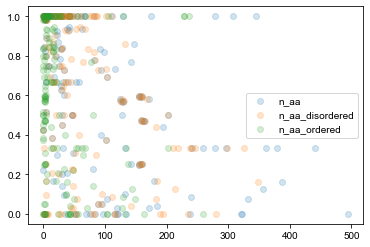

In [24]:
fig, ax = plt.subplots(1, 1)
y = 'ppi_jaccard'
for c in n_aa.columns:
    x = f'abs_delta_{c}'
    ax.scatter(pairs.loc[pairs[x].notnull() & pairs[y].notnull(), x],
            pairs.loc[pairs[x].notnull() & pairs[y].notnull(), y],
            alpha=0.2,
            label=c)
ax.legend()

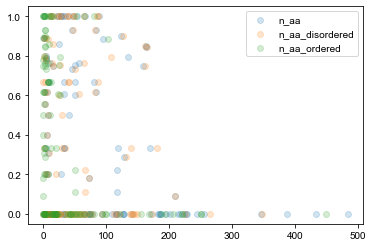

In [25]:
fig, ax = plt.subplots(1, 1)
y = 'pdi_jaccard'
for c in n_aa.columns:
    x = f'abs_delta_{c}'
    ax.scatter(pairs.loc[pairs[x].notnull() & pairs[y].notnull(), x],
            pairs.loc[pairs[x].notnull() & pairs[y].notnull(), y],
            alpha=0.2,
            label=c)
ax.legend()

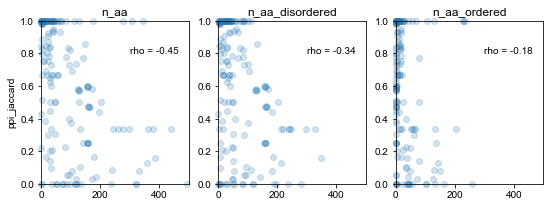

In [52]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(h=3, w=9)
y_col = 'ppi_jaccard'
axs[0].set_ylabel(y_col)
for c, ax in zip(n_aa.columns, axs):
    x_col = f'abs_delta_{c}'
    x = pairs.loc[pairs[x_col].notnull() & pairs[y_col].notnull(), x_col]
    y = pairs.loc[pairs[x_col].notnull() & pairs[y_col].notnull(), y_col]
    ax.scatter(x, y, alpha=0.2, label=c, clip_on=False)
    ax.set_title(c)
    ax.text(x=300, y=0.8, s=f'rho = {stats.spearmanr(x, y)[0]:.2f}')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 500)
fig.savefig('../figures/test2_scatter_disorder.pdf')

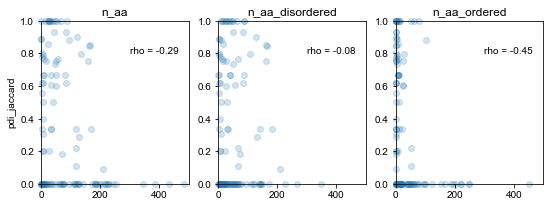

In [51]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(h=3, w=9)
y_col = 'pdi_jaccard'
axs[0].set_ylabel(y_col)
for c, ax in zip(n_aa.columns, axs):
    x_col = f'abs_delta_{c}'
    x = pairs.loc[pairs[x_col].notnull() & pairs[y_col].notnull(), x_col]
    y = pairs.loc[pairs[x_col].notnull() & pairs[y_col].notnull(), y_col]
    ax.scatter(x, y, alpha=0.2, label=c, clip_on=False)
    ax.set_title(c)
    ax.text(x=300, y=0.8, s=f'rho = {stats.spearmanr(x, y)[0]:.2f}')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 500)
fig.savefig('../figures/test3_scatter_disorder.pdf')

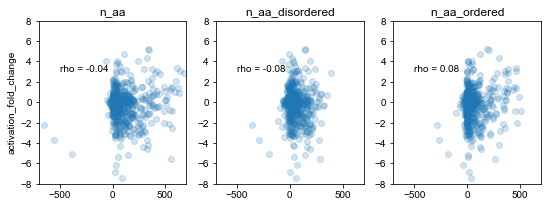

In [53]:
from scipy import stats

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(h=3, w=9)
y_col = 'activation_fold_change'
axs[0].set_ylabel(y_col)
for c, ax in zip(n_aa.columns, axs):
    x_col = f'delta_{c}'
    x = pairs.loc[pairs[x_col].notnull() & pairs[y_col].notnull(), x_col]
    y = pairs.loc[pairs[x_col].notnull() & pairs[y_col].notnull(), y_col]
    ax.scatter(x, y, alpha=0.2, label=c)
    ax.set_title(c)
    ax.text(x=-500, y=3, s=f'rho = {stats.spearmanr(x, y)[0]:.2f}')
    ax.set_ylim(-8, 8)
    ax.set_xlim(-700, 700)
fig.savefig('../figures/test_scatter_disorder.pdf')

In [57]:
n_aa.loc[n_aa['n_aa_ordered'] == 0].sort_values('n_aa_disordered', ascending=False)

,n_aa,n_aa_disordered,n_aa_ordered
clone_name,,,
FOXO3-2,453,453.0,0.0
PLAGL1-2,252,252.0,0.0
NFAT5-1,242,242.0,0.0
SALL2-3,200,200.0,0.0
SALL2-2,198,198.0,0.0
SPIB-1,178,178.0,0.0
FOS-3,170,170.0,0.0
SP2-5,170,170.0,0.0
ZNF280D-2,158,158.0,0.0


In [129]:
f_dis.sort_values()

clone_name
ZNF415-4    0.0
ZNF415-3    0.0
TBPL1-1     0.0
ZBTB25-4    0.0
KLF7-6      0.0
           ... 
ZNF696-2    1.0
ZNF23-3     1.0
ZNF175-3    1.0
ZNF772-4    1.0
DLX5-2      1.0
Name: is_disordered, Length: 742, dtype: float64